In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import xarray as xr
import scipy.stats as stat
import scipy.interpolate as inter
import metcalc

In [2]:
def remove_axes(ax) :
    spines_to_keep = ['left', 'bottom']     
    for spine in spines_to_keep:
        ax.spines[spine].set_linewidth(0.5)
    spines_to_remove = ['top', 'right'] 
    for spine in spines_to_remove:
        ax.spines[spine].set_visible(False)
        

# Read Files

Read files that were preprocessed with the intake script.


In [3]:
TA_FILE   = '../data/ta/ta_tropical_mean_timemean_piControl.nc'
TA_AMIP_FILE   = '../data/ta/ta_tropical_mean_ym_amip.nc'
TA_AMIP_SAMPLED_FILE = '../data/amip/ta/ta_tropical_mean_subsmapledIUK_timemean_amip.nc'
PRSST_FILE   = '../data/PRSST/PRSST_20_piControl.nc'
PRTA_FILE   = '../data/PRTA/PRTA_20_piControl.nc'
TA_SAMPLED_FILE   = '../data/ta/ta_tropical_mean_subsmapledIUK_timemean_all.nc'

PLOT_DIR  = "../plots/"

names_ta   = TA_FILE
names_ta_amip   = TA_AMIP_FILE
names_ta_amip_sampled   = TA_AMIP_SAMPLED_FILE
names_ta_sampled   = TA_SAMPLED_FILE
names_prsst   = PRSST_FILE
names_prta   = PRTA_FILE


## Models

In [4]:
def format_dataset(ds) :
    ds.coords['plev2'] = ds.plev / 100.
    ds = ds.swap_dims({'plev': 'plev2'}).squeeze(drop='true')
    return ds

In [5]:
ta_piC = xr.open_dataset(TA_FILE)
ta_piC = format_dataset(ta_piC)
ta_piC_sampled = xr.open_dataset(TA_SAMPLED_FILE)
ta_piC_sampled = format_dataset(ta_piC_sampled)
ta_amip = xr.open_dataset(TA_AMIP_FILE)
ta_amip = format_dataset(ta_amip)
ta_amip_sampled = xr.open_dataset(TA_AMIP_SAMPLED)
ta_amip_sampled = format_dataset(ta_amip_sampled)
PRSST = xr.open_dataset(PRSST_FILE)
PRTA = xr.open_dataset(PRTA_FILE)

## Observations

In [6]:
OBS_FILE2 = '../data/radiosondes/iuk_20N-20S.nc'
name_obs_t2=WORK_DIR+OBS_FILE2

ta_obs_iuk = xr.open_dataset(name_obs_t2)
ta_obs_iuk = ta_obs_iuk.rename({'plev' : 'plev2', 'T_mm' : 'ta'})
ta_obs_iuk['ta'] = ta_obs_iuk['ta'] + 273.15
ta_obs_iuk['ta700']=ta_obs_iuk.sel(plev2=700).ta

ta_obs_iuk_1979_2014 = ta_obs_iuk.sel(month = slice(1979011500,2014121500))
ta_obs_iuk_1979_2014_timmean = ta_obs_iuk_1979_2014.mean('month')
ta_obs_iuk_1979_2014_timmean_station_mean = ta_obs_iuk_1979_2014_timmean.mean('station')

ta_obs_iuk_1979_2014_timmean_station_std = ta_obs_iuk_1979_2014_timmean.std('station')

In [7]:
ta_obs_iuk_1979_2014_timmean

<xarray.Dataset>
Dimensions:                 (plev2: 12, station: 69)
Coordinates:
  * station                 (station) int32 91765 94120 78954 ... 91285 48900
  * plev2                   (plev2) float64 850.0 700.0 500.0 ... 70.0 50.0 30.0
Data variables:
    ta                      (plev2, station) float32 289.5 291.4 ... 218.0 215.0
    structural_uncertainty  (plev2, station) float32 0.5755 0.1814 ... -555.3
    sample_uncertainty      (plev2, station) float32 -462.8 ... -9.791e+03
    latlist                 (station) float32 -14.33 -12.43 ... 19.72 10.82
    lonlist                 (station) float32 189.3 130.9 300.5 ... 204.9 106.7
    ta700                   (station) float32 281.8 283.0 282.1 ... 281.1 283.0

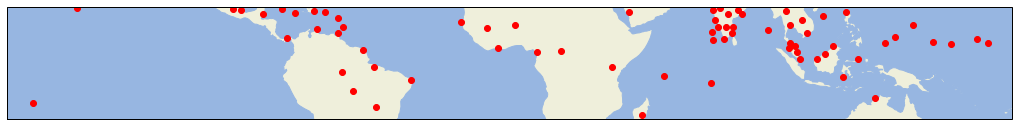

In [8]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
lat_border=20

fig = plt.figure(figsize=(18, 3))

ax = fig.add_subplot(1, 1, 1,projection=ccrs.PlateCarree())
ax.set_extent([0, 359, -lat_border, lat_border], crs=ccrs.PlateCarree())

ax.scatter(ta_obs_iuk_1979_2014_timmean.lonlist.values,ta_obs_iuk_1979_2014_timmean.latlist.values,c='red',transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)



## ERA5

ERA5 data can be downloaded here https://confluence.ecmwf.int/display/CKB/How+to+download+ERA5

We also use ERA 5.1 for years 2000-2006, which has a bias correction in stratospheric temperatures. Overall this does not make a huge difference however.

In [9]:
ERA_FILE = '../data/era5/era5_T_ym_tropical_mean20_1979-2014.nc'
name_era=WORK_DIR+ERA_FILE

era_levels = [1000,850,700,600,500,400,300,250,200,150]
era_levels.remove(400)

ta_era = xr.open_dataset(name_era).T
ta_era.coords['plev2'] = ta_era.plev / 100.
ta_era = ta_era.swap_dims({'plev': 'plev2'}).squeeze(drop='true').sel(plev2=era_levels)

ta_era = ta_era.to_dataset(name = 'ta').assign_coords(time = np.arange(1979.,2015.))
ta_era['ta700']=ta_era.sel(plev2=700).ta
#ta_era_timemean = ta_era.mean('time')

ta_era_1979_1999 = ta_era.sel(time=slice(1979,1999))
ta_era_2007_2014 = ta_era.sel(time=slice(2007,2014))

In [10]:
# try era5.1:

ERA51_FILE = '../data/era5/era5.1_T_mm_fldmean_lat20_2000-2006.nc'
name_era51=WORK_DIR+ERA51_FILE

ta_era51 = xr.open_dataset(name_era51).T
ta_era51.coords['plev2'] = ta_era51.plev / 100.
ta_era51 = ta_era51.swap_dims({'plev': 'plev2'}).squeeze(drop='true').sel(plev2=era_levels)


ta_era51 = ta_era51.to_dataset(name = 'ta')
ta_era51['ta700']=ta_era51.sel(plev2=700).ta
ta_era51 = ta_era51.sortby("time").resample(time='Y').mean().assign_coords(time = np.arange(2000.,2007.))
ta_era51

<xarray.Dataset>
Dimensions:  (plev2: 9, time: 7)
Coordinates:
  * time     (time) float64 2e+03 2.001e+03 2.002e+03 ... 2.005e+03 2.006e+03
    plev     (plev2) float64 1e+05 8.5e+04 7e+04 6e+04 ... 2.5e+04 2e+04 1.5e+04
  * plev2    (plev2) float64 1e+03 850.0 700.0 600.0 ... 300.0 250.0 200.0 150.0
Data variables:
    ta       (time, plev2) float32 298.4 290.5 282.3 275.1 ... 231.8 219.8 205.7
    ta700    (time) float32 282.3 282.4 282.6 282.7 282.6 282.8 282.6

### Compare ERA5 and ERA5.1
Only very marginal differences

In [11]:
ta_era.sel(time=slice(2000,2006)).sel(plev2=150).ta - ta_era51.sel(plev2=150).ta

<xarray.Dataset>
Dimensions:  (time: 7)
Coordinates:
  * time     (time) float64 2e+03 2.001e+03 2.002e+03 ... 2.005e+03 2.006e+03
    plev     float64 1.5e+04
    plev2    float64 150.0
Data variables:
    ta       (time) float32 ...
    ta700    (time) float32 ...

In [13]:
ta_era5_and_51 = xr.concat([ta_era_1979_1999,ta_era51,ta_era_2007_2014],"time")
ta_era5_and_51_timemean = ta_era5_and_51.mean("time")
ta_era5_and_51


<xarray.Dataset>
Dimensions:  (plev2: 9, time: 36)
Coordinates:
  * time     (time) float64 1.979e+03 1.98e+03 1.981e+03 ... 2.013e+03 2.014e+03
    plev     (plev2) float64 1e+05 8.5e+04 7e+04 6e+04 ... 2.5e+04 2e+04 1.5e+04
  * plev2    (plev2) float64 1e+03 850.0 700.0 600.0 ... 300.0 250.0 200.0 150.0
Data variables:
    ta       (time, plev2) float32 298.5 290.7 282.6 275.5 ... 231.9 219.9 205.8
    ta700    (time) float32 282.6 282.6 282.4 282.4 ... 282.6 282.6 282.8 282.8

## Merge model data

In [14]:
ta_piC['ta700']=ta_piC.sel(plev2=700).ta
ta_piC['prsst']=PRSST.PRSST
ta_piC['prta700']=PRTA.PRTA

ta_amip['ta700']=ta_amip.sel(plev2=700).ta
ta_amip_timemean = ta_amip.mean('time')

ta_amip_sampled['ta700']=ta_amip_sampled.sel(plev2=700).ta
ta_piC_sampled['ta700']=ta_piC_sampled.sel(plev2=700).ta

# level in upper troposphere used for the analysis:
upper_level=250


The PRTA calculation does not work for two mdoels, because their grids of the precip and temerature are slightly different, so we omit them

In [15]:
PRTA = PRTA.dropna(dim='model_id')

In [16]:
PRTA

<xarray.Dataset>
Dimensions:    (model_id: 49)
Coordinates:
    member_id  object ...
    plev       float64 ...
  * model_id   (model_id) object 'BCC-ESM1' 'FGOALS-f3-L' ... 'CMCC-ESM2'
Data variables:
    PRTA       (model_id) float64 282.7 280.4 281.7 282.1 ... 282.1 281.4 281.6

## Take a look at the data:

In [17]:
ta_piC

<xarray.Dataset>
Dimensions:    (model_id: 51, plev2: 11)
Coordinates:
  * model_id   (model_id) object 'BCC-ESM1' 'E3SM-1-1' ... 'CMCC-ESM2'
    plev       (plev2) float64 1e+05 8.5e+04 7e+04 6e+04 ... 1.5e+04 1e+04 5e+03
    member_id  object ...
  * plev2      (plev2) float64 1e+03 850.0 700.0 600.0 ... 150.0 100.0 50.0
Data variables:
    ta         (model_id, plev2) float64 ...
    ta700      (model_id) float64 ...
    prsst      (model_id) float64 301.4 301.1 300.6 300.4 ... 300.7 301.2 301.4
    prta700    (model_id) float64 282.7 281.1 281.6 279.3 ... 280.8 281.6 281.6

In [18]:
ta_amip.mean('time')

<xarray.Dataset>
Dimensions:    (model_id: 40, plev2: 11)
Coordinates:
    plev       (plev2) float64 1e+05 8.5e+04 7e+04 6e+04 ... 1.5e+04 1e+04 5e+03
    member_id  object ...
  * model_id   (model_id) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'EC-Earth3-CC'
  * plev2      (plev2) float64 1e+03 850.0 700.0 600.0 ... 150.0 100.0 50.0
Data variables:
    ta         (model_id, plev2) float64 298.5 291.1 282.2 ... 204.7 191.5 208.8
    ta700      (model_id) float64 282.2 283.1 282.6 282.5 ... 282.0 282.1 282.0

# Plot

Calcualte some theoretical adiabats

In [19]:
temperatures = np.arange(278,284,0.1)
qt=15.e-3
T_pseudo=[]
T_revers=[]

for T in temperatures :
    Tx, Px = metcalc.integrate_dTdP(T,70000.,15000.,-100., qt, formula='pseudo')
    index_250hPa = np.where( Px == 25000 )
    T_pseudo.append(Tx[index_250hPa])
    Tx, Px = metcalc.integrate_dTdP(T,70000.,15000.,-100., qt, formula='isentrope')
    T_revers.append(Tx[index_250hPa])

In [20]:
regress_pseudo = stat.linregress(temperatures, [ float(l) for l in T_pseudo ])
regress_revers = stat.linregress(temperatures, [ float(l) for l in T_revers ])

In [21]:
regress_pseudo

LinregressResult(slope=1.990678910887619, intercept=-330.97415731346337, rvalue=0.9997470139115396, pvalue=2.7323708190416823e-97, stderr=0.005880753175798362)

In [22]:
regress_revers

LinregressResult(slope=1.8856659399430027, intercept=-299.0962957285432, rvalue=0.999799456639274, pvalue=3.24403628500308e-100, stderr=0.004959469580450428)

## Plot settings

In [23]:
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.size': 7})

## CMIP6 piControl and AMIP temperature

In [24]:
upper_lev = 250

In [25]:
temp = ta_piC.sel(plev2=upper_level).drop('plev').drop('plev2')
correlation_piControl = metcalc.pearson_correlation(temp.ta700, temp.ta , 'model_id')

x=ta_piC.ta700.values
y=ta_piC.sel(plev2=upper_level).ta.values
regress_piC = stat.linregress(x, y)
correlation_piControl

<xarray.DataArray ()>
array(0.78621634)
Coordinates:
    member_id  <U8 'r1i1p1f1'

In [26]:
temp = ta_amip_timemean.sel(plev2=upper_level).drop('plev').drop('plev2')
correlation_amip = metcalc.pearson_correlation(temp.ta700, temp.ta , 'model_id')

x=ta_amip_timemean.ta700.values
y=ta_amip_timemean.sel(plev2=upper_level).ta.values
regress_amip = stat.linregress(x, y)
correlation_amip

<xarray.DataArray ()>
array(0.53816514)
Coordinates:
    member_id  <U8 'r1i1p1f1'

/home/mpim/m300577/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


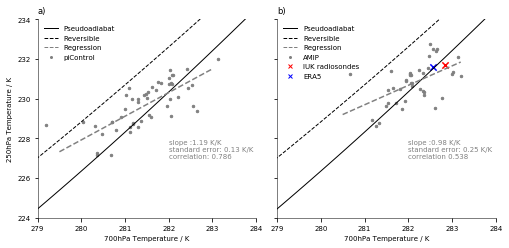

In [27]:
lines=[]

fig, axes = plt.subplots(1,2, figsize=(18/2.54,8.8/2.54),facecolor='w',sharey=True)

ax=axes[0]

ax.plot(temperatures, T_pseudo, color='black',linewidth=1)
lines.append(mlines.Line2D([], [], color='black',linewidth=1, label='Pseudoadiabat'))

ax.plot(temperatures, T_revers, color='black',linewidth=1,ls='--')
lines.append(mlines.Line2D([], [], color='black',linewidth=1,ls='--', label='Reversible'))

ax.plot(np.array((279.5,283)), regress_piC.slope*np.array((279.5,283)) + regress_piC.intercept, color='grey',ls='--' )
lines.append(mlines.Line2D([], [], color='grey',linewidth=1, label='Regression',ls='--'))

ta_piC.sel(plev2=upper_level).plot.scatter(x='ta700',y='ta',c='grey',s=6,marker='o',ax=ax)
lines.append(mlines.Line2D([], [], color='grey',marker='o',markersize=2, label='piControl', linewidth=0))



ax.set_xlabel('700hPa Temperature / K')
ax.set_ylabel(str(upper_level) + 'hPa Temperature / K')
ax.set_title('a)',loc="left")
ax.set_xlim([279,284])
ax.set_ylim([224,234])
ax.set_xticks([279,280,281,282,283,284])
ax.set_yticks([224,226,228,230,232,234])

ax.text(s='slope :' + str(np.round(regress_piC.slope,2)) + ' K/K\n\
standard error: '+ str(np.round(regress_piC.stderr,2)) +' K/K\n\
correlation: %.3f'%(correlation_piControl.values) ,
x=282,y=227,color='grey')

remove_axes(ax)

ax.legend(handles=lines,ncol=1,frameon=False,loc=2)

lines=[]
ax=axes[1]


ax.plot(temperatures, T_pseudo, color='black',linewidth=1)
lines.append(mlines.Line2D([], [], color='black',linewidth=1, label='Pseudoadiabat'))

ax.plot(temperatures, T_revers, color='black',linewidth=1,ls='--')
lines.append(mlines.Line2D([], [], color='black',linewidth=1,ls='--', label='Reversible'))

ax.plot(np.array((280.5,283.2)), regress_amip.slope*np.array((280.5,283.2)) + regress_amip.intercept, color='grey',ls='--' )
lines.append(mlines.Line2D([], [], color='grey',linewidth=1, label='Regression',ls='--'))

ta_amip_timemean.sel(plev2=upper_lev).plot.scatter(x='ta700',y='ta',c='grey',s=6,marker='o')
lines.append(mlines.Line2D([], [], color='grey',marker='o',markersize=2, label='AMIP', linewidth=0))

ta_obs_iuk_1979_2014_timmean_station_mean.sel(plev2=upper_lev).plot.scatter(x='ta700',y='ta',c='red',s=40,marker='x')
lines.append(mlines.Line2D([], [], color='red',marker='x',markersize=4, label='IUK radiosondes', linewidth=0))

ta_era5_and_51_timemean.sel(plev2=upper_lev).plot.scatter(x='ta700',y='ta',c='blue',s=40,marker='x')
lines.append(mlines.Line2D([], [], color='blue',marker='x',markersize=4, label='ERA5', linewidth=0))


ax.set_xlim([279,284])
#ax.set_ylim([224,234])
ax.set_xticks([279,280,281,282,283,284])
#ax.set_yticks([224,226,228,230,232,234])
#ax.set_yticklabels([])

ax.text(s='slope :' + str(np.round(regress_amip.slope,2)) + ' K/K\n\
standard error: ' + str(np.round(regress_amip.stderr,2)) + ' K/K\n\
correlation %.3f'%(correlation_amip),x=282,y=227,color='grey')


ax.set_xlabel('700hPa Temperature / K')
ax.set_ylabel('')
ax.set_title('b)',loc="left")

remove_axes(ax)

ax.legend(handles=lines,ncol=1,frameon=False,loc=2)

   
plt.savefig('../plots/cmip6_piC+AMIP_temp_700vs250.pdf', dpi=600)


Quantify difference to pseudoadiabat:

In [28]:
upper_trop_T_from_ma = regress_piC.slope*ta_piC.ta700 + regress_piC.intercept

diff_to_ma = ta_piC.sel(plev2=upper_level).ta - upper_trop_T_from_ma

print(max(abs(diff_to_ma)))

<xarray.DataArray ()>
array(1.72502792)
Coordinates:
    model_id   <U12 'IPSL-CM6A-LR'
    plev       float64 2.5e+04
    member_id  <U8 'r1i1p1f1'
    plev2      float64 250.0


In [29]:
upper_trop_T_from_ma = regress_amip.slope*ta_amip_timemean.ta700 + regress_amip.intercept

diff_to_ma = ta_amip_timemean.sel(plev2=upper_level).ta - upper_trop_T_from_ma

print(max(abs(diff_to_ma)))

<xarray.DataArray ()>
array(1.89415367)
Coordinates:
    plev       float64 2.5e+04
    member_id  <U8 'r1i1p1f1'
    model_id   <U12 'IPSL-CM6A-LR'
    plev2      float64 250.0


Sampled gridpoints to radiosonde stations:

Differences are very small

In [30]:
ta_piC_sampled.sel(plev2=upper_lev) - ta_piC.sel(plev2=upper_lev)

<xarray.Dataset>
Dimensions:    (model_id: 51)
Coordinates:
    plev       float64 2.5e+04
    member_id  <U8 'r1i1p1f1'
  * model_id   (model_id) object 'BCC-ESM1' 'E3SM-1-1' ... 'CMCC-ESM2'
    plev2      float64 250.0
Data variables:
    ta         (model_id) float64 0.1983 0.196 0.2134 ... 0.102 0.1835 0.2032
    ta700      (model_id) float64 -0.02538 0.2541 0.09372 ... -0.07466 -0.02929

/home/mpim/m300577/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


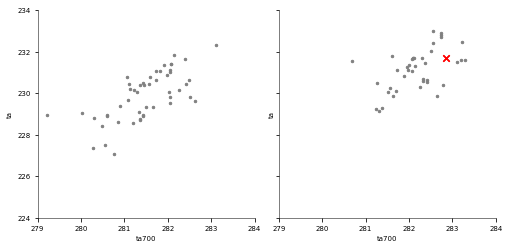

In [31]:
fig, axes = plt.subplots(1,2, figsize=(18/2.54,8.8/2.54),facecolor='w',sharey=True)
ax=axes[0]
ta_piC_sampled.sel(plev2=upper_lev).plot.scatter(x='ta700',y='ta',c='grey',s=6,marker='o',ax=ax)
ax.set_xlim([279,284])
ax.set_ylim([224,234])
ax.set_xticks([279,280,281,282,283,284])
ta_obs_iuk_1979_2014_timmean_station_mean.sel(plev2=upper_lev).plot.scatter(x='ta700',y='ta',c='red',s=40,marker='x')
remove_axes(ax)


ax=axes[1]
ta_amip_sampled.sel(plev2=upper_lev).plot.scatter(x='ta700',y='ta',c='grey',s=6,marker='o',ax=ax)
ax.set_xlim([279,284])
ax.set_ylim([224,234])
ax.set_xticks([279,280,281,282,283,284])
ta_obs_iuk_1979_2014_timmean_station_mean.sel(plev2=upper_lev).plot.scatter(x='ta700',y='ta',c='red',s=40,marker='x')
remove_axes(ax)


## CMIP6 PRSST and PRTA

In [32]:
common_list_PRSST = []
for mod in PRSST.model_id :
    exist = False
    for model in ta_piC.model_id :
        if model == mod :
            exist = True
            common_list_PRSST.append(model.values)
    if exist == False :
        print(str(mod.values) + " does not exist in piC dataset")
    

GISS-E2-1-G-CC does not exist in piC dataset
KACE-1-0-G does not exist in piC dataset


In [33]:
common_list_PRTA = []
for mod in PRTA.model_id :
    exist = False
    for model in ta_piC.model_id :
        if model == mod :
            exist = True
            common_list_PRTA.append(model.values)
    if exist == False :
        print(str(mod.values) + " does not exist in piC dataset")
    

In [34]:
x=ta_piC.sel(model_id=common_list_PRSST).prsst.values
y=ta_piC.sel(plev2=upper_level,model_id=common_list_PRSST).ta.values
regress_prsst = stat.linregress(x, y)

correlation_prsst,p=stat.pearsonr(x, y)

correlation_prsst

0.6749659903613855

In [35]:
len(x)

50

In [36]:
x=ta_piC.sel(model_id=common_list_PRTA).prta700.values
y=ta_piC.sel(plev2=upper_level,model_id=common_list_PRTA).ta.values

regress_prta = stat.linregress(x, y)

correlation_prta,p = stat.pearsonr(x, y)

correlation_prta

0.7461740175793447

In [37]:
len(x)

49

/home/mpim/m300577/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


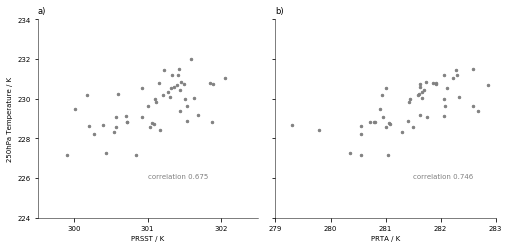

In [38]:

fig, axes = plt.subplots(1,2, figsize=(18/2.54,8.8/2.54),facecolor='w',sharey=True)

ax=axes[0]

ta_piC.sel(plev2=upper_level).plot.scatter(x='prsst',y='ta',c='grey',s=6,marker='o',ax=ax)

#ax.plot(np.array((279.5,283)), regress.slope*np.array((280,283)) + regress.intercept, color='grey',ls='--' )

ax.set_xlabel('PRSST / K')
ax.set_ylabel(str(upper_level) + 'hPa Temperature / K')


ax.set_title('a)',loc="left")

ax.set_xlim(299.5,302.5)
ax.set_ylim(224,234)
ax.set_xticks([300,301,302])
ax.set_yticks([224,226,228,230,232,234])

ax.text(s='correlation %.3f'%(correlation_prsst),x=301,y=226,color='grey')

remove_axes(ax)
  
lines=[]
ax=axes[1]
    
ta_piC.sel(plev2=upper_level).plot.scatter(x='prta700',y='ta',c='grey',s=6,marker='o',ax=ax)

ax.set_xlabel('PRTA / K')
ax.set_ylabel('')

ax.set_title('b)',loc="left")

ax.set_xlim(279,283)
#ax.set_ylim(224,234)
ax.set_xticks([279,280,281,282,283])
#ax.set_yticks([224,226,228,230,232,234])

ax.text(s='correlation %.3f'%(correlation_prta),x=281.5,y=226,color='grey')

remove_axes(ax)
  
plt.savefig('../plots/cmip6_piC_PRSST_vs_ta250.pdf', dpi=600)

## Deviations from moist adiabat:
We take the mean over the radiosonde stations. The median has been used by e.g. Sherwood 2015 and looks very similar. We stick to the mean to make it more consistent.

In [39]:

ta_piC_dev = metcalc.deviations_from_moist_adiabat(ta_piC,plev_i=2,ensemble_name='model_id')
ta_dev_obs = metcalc.deviations_from_moist_adiabat(ta_obs_iuk_1979_2014_timmean,plev_i=1,ensemble_name='station')
ta_dev_era = metcalc.deviations_from_moist_adiabat(ta_era5_and_51_timemean,plev_i=2)



ta_dev_obs_mean=ta_dev_obs.mean(dim='station')
ta_piC_dev_model_mean=ta_piC_dev.mean(dim='model_id')


selected starting level: 700.0 hPa
selected starting level: 700.0 hPa
selected starting level: 700.0 hPa


Calculate some idelised moist adiabats:

In [40]:
ta700_model_mean = ta_piC.mean('model_id').ta700.values

print(ta700_model_mean)

ta = float(ta700_model_mean)

# Chose 18g/kg as in Bao and Stevens
qt=18.e-3
T_pseudo, Px = metcalc.integrate_dTdP(ta,70000.,15000.,-100., qt, formula='pseudo')
T_isen, Px = metcalc.integrate_dTdP(ta,70000.,15000.,-100., qt ,formula='isentrope')
T_pseudo_ice, Px = metcalc.integrate_dTdP(ta,70000.,15000.,-100., qt ,formula='pseudo-ice')
T_isen_ice, Px = metcalc.integrate_dTdP(ta,70000.,15000.,-100., qt ,formula='ice-isentrope')
T_mixed, Px = metcalc.integrate_dTdP(ta,70000.,15000.,-100., qt ,formula='mixed',con_factor = 0.5)
T_pseudo_mixed, Px = metcalc.integrate_dTdP(ta,70000.,15000.,-100., qt ,formula='pseudo-mixed',ice_factor = 0.5)

281.40211565257067


In [41]:
delta_T_entr, _, _ = metcalc.dT_entrainment_700(295.,96000.,0.8,0.3)

Calculate differences of idealised lines:

In [42]:

T_isen_diff = T_isen - T_pseudo
T_pseudo_ice_diff = T_pseudo_ice - T_pseudo
T_isen_ice_diff = T_isen_ice - T_pseudo
T_mixed_diff = T_mixed - T_pseudo
T_pseudo_mixed_diff = T_pseudo_mixed - T_pseudo


/home/mpim/m300577/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


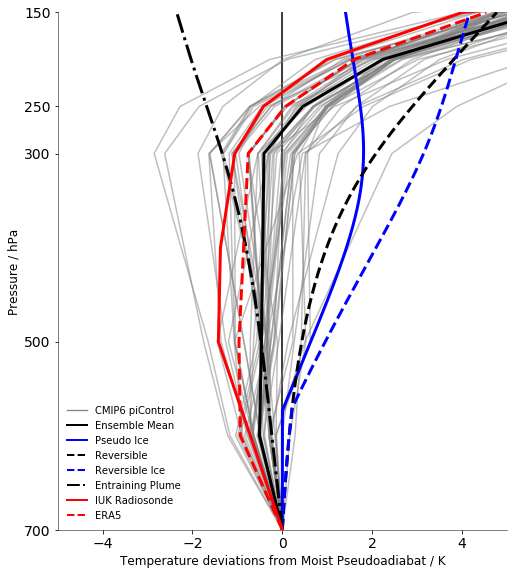

In [43]:
lines=[]

fig,ax = plt.subplots(figsize=(7.2, 8),facecolor='w')

ax.plot([0,0],[1000,50],color='black')

ta_piC_dev['ta'].plot(y='plev2',color='grey',ls='-',alpha=0.5,linewidth=1.5,hue='model_id')
lines.append(mlines.Line2D([], [],linewidth=1.3,color='grey',label='CMIP6 piControl'))

ta_piC_dev_model_mean['ta'].plot(y='plev2',linewidth=3,color='black')
lines.append(mlines.Line2D([], [],linewidth=2,color='black',label='Ensemble Mean'))

ax.plot(T_pseudo_ice_diff,Px/100.,color='blue',linewidth=3)
lines.append(mlines.Line2D([], [],linewidth=2,color='blue',label='Pseudo Ice'))

ax.plot(T_isen_diff,Px/100.,color='black',ls='--',linewidth=3)
lines.append(mlines.Line2D([], [],linewidth=2,color='black',ls='--',label='Reversible'))

ax.plot(T_isen_ice_diff,Px/100.,color='blue',linewidth=3,ls='--')
lines.append(mlines.Line2D([], [],linewidth=2,color='blue',label='Reversible Ice',ls='--'))

ax.plot(-delta_T_entr[:-1],Px[:-1]/100.,color='black',linewidth=3,ls='-.')
lines.append(mlines.Line2D([], [],linewidth=2,color='black',label='Entraining Plume',ls='-.'))

ta_dev_obs_mean['ta'].plot(y='plev2',color='red',linewidth=3)
lines.append(mlines.Line2D([], [],linewidth=2,color='red',label='IUK Radiosonde'))

ta_dev_era['ta'].plot(y='plev2',color='red',linewidth=3,ls='--')
lines.append(mlines.Line2D([], [],linewidth=2,ls='--',color='red',label='ERA5'))


ax.set_ylim(700, 150) 
ax.set_xlim(-5, 5)
ax.set_yticks([700,500,300,250,150])

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

ax.set_ylabel('Pressure / hPa',size=12)
ax.set_xlabel('Temperature deviations from Moist Pseudoadiabat / K',size=12)

plt.legend(handles=lines,ncol=1,prop={'size': 10},frameon=False)

spines_to_keep = ['left', 'bottom']     
for spine in spines_to_keep:
    ax.spines[spine].set_linewidth(0.5)
spines_to_remove = ['top', 'right'] 
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)



plt.savefig('../plots/cmip6_piC_dev_pseudo+more+obs.pdf', dpi=600)




In [44]:

ta_piC_sampled_dev = metcalc.deviations_from_moist_adiabat(ta_piC_sampled,plev_i=2,ensemble_name='model_id')
ta_piC_sampled_dev_model_mean=ta_piC_sampled_dev.mean(dim='model_id')


selected starting level: 700.0 hPa


/home/mpim/m300577/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


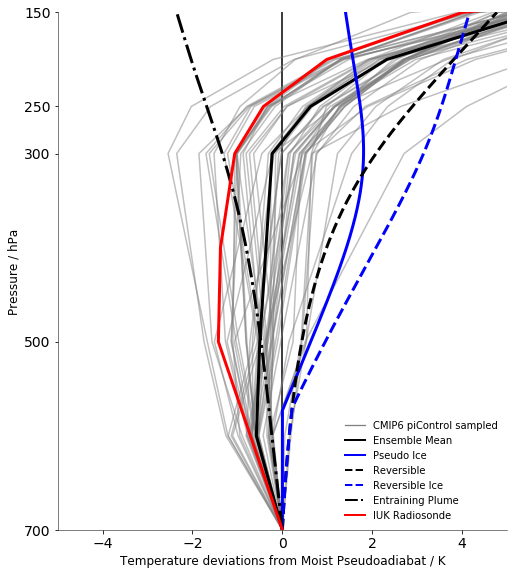

In [45]:
lines=[]

fig,ax = plt.subplots(figsize=(7.2, 8),facecolor='w')

ax.plot([0,0],[1000,50],color='black')

ta_piC_sampled_dev['ta'].plot(y='plev2',color='grey',ls='-',alpha=0.5,linewidth=1.5,hue='model_id')
lines.append(mlines.Line2D([], [],linewidth=1.3,color='grey',label='CMIP6 piControl sampled'))

ta_piC_sampled_dev_model_mean['ta'].plot(y='plev2',linewidth=3,color='black')
lines.append(mlines.Line2D([], [],linewidth=2,color='black',label='Ensemble Mean'))

ax.plot(T_pseudo_ice_diff,Px/100.,color='blue',linewidth=3)
lines.append(mlines.Line2D([], [],linewidth=2,color='blue',label='Pseudo Ice'))

ax.plot(T_isen_diff,Px/100.,color='black',ls='--',linewidth=3)
lines.append(mlines.Line2D([], [],linewidth=2,color='black',ls='--',label='Reversible'))

ax.plot(T_isen_ice_diff,Px/100.,color='blue',linewidth=3,ls='--')
lines.append(mlines.Line2D([], [],linewidth=2,color='blue',label='Reversible Ice',ls='--'))

ax.plot(-delta_T_entr[:-1],Px[:-1]/100.,color='black',linewidth=3,ls='-.')
lines.append(mlines.Line2D([], [],linewidth=2,color='black',label='Entraining Plume',ls='-.'))

ta_dev_obs_mean['ta'].plot(y='plev2',color='red',linewidth=3)
lines.append(mlines.Line2D([], [],linewidth=2,color='red',label='IUK Radiosonde'))

#ta_dev_era['ta'].plot(y='plev2',color='red',linewidth=3,ls='--')
#lines.append(mlines.Line2D([], [],linewidth=2,ls='--',color='red',label='ERA5'))


ax.set_ylim(700, 150) 
ax.set_xlim(-5, 5)
ax.set_yticks([700,500,300,250,150])

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

ax.set_ylabel('Pressure / hPa',size=12)
ax.set_xlabel('Temperature deviations from Moist Pseudoadiabat / K',size=12)

plt.legend(handles=lines,ncol=1,prop={'size': 10},frameon=False)

spines_to_keep = ['left', 'bottom']     
for spine in spines_to_keep:
    ax.spines[spine].set_linewidth(0.5)
spines_to_remove = ['top', 'right'] 
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)

